In [3]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import xarray as xr
from patsy import dmatrix

%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.10.3


This notebook consists of some checks to replicate simple models made using frequentist libraries such as statsmodels or mgcv in R. Firstly, the posterior distribution of a Binomial sample with Beta prior is computed. The Binomial and Beta distribution are called prior, meaning that if X~Bin(n,p) and p~Beta(\alpha, \beta), then the distribution p|X~Beta(\alpha^*,\beta^*). The latter is what we call a posterior and is computed easily. This allows to check how well PyMC performs.  

In the next chunk we compute the posterior using MCMC sampling. The chunk after that plots the analytical posterior. The posterior plots appear to be almost equal, which is a good thing. Note that in this first simple example, a Beta(1,1) prior is used. This is simply a uniform prior having the same mass over the whole interval [0,1]. If more was known about the situation, like if we knew it was a coin with more or less even edges, the probability should be around 50%. But in cases when it is about incidence rates of a disease, this probability may not be so certain. Choosing other parameters in the Beta distribution for the prior puts more mass elsewhere on the unit interval.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [probability]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 29 seconds.


array([[<Axes: title={'center': 'probability'}>,
        <Axes: title={'center': 'probability'}>]], dtype=object)

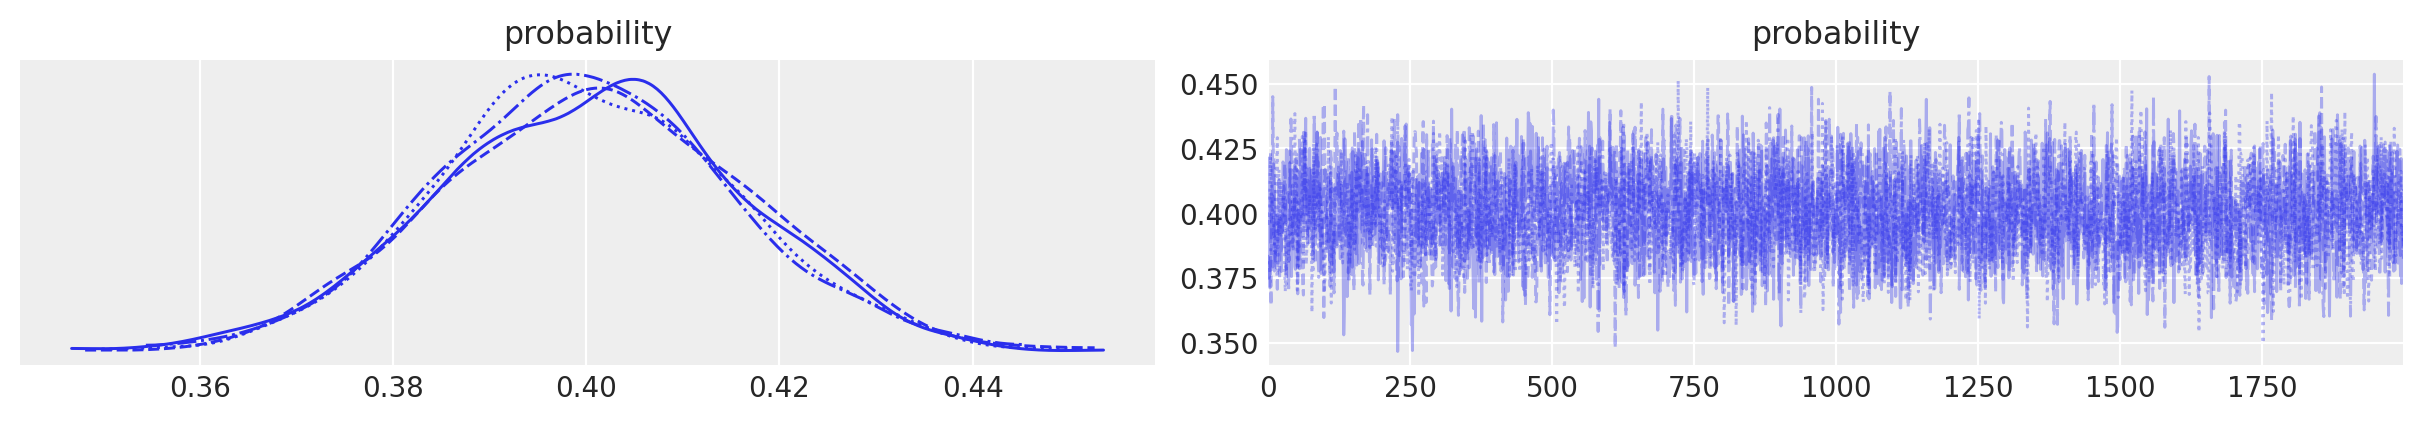

In [103]:
# Generate a binomial sample (artificially with 400 successes)
N = 1000
k = 400

with pm.Model() as model:
    p = pm.Beta("probability", 1, 1)
    likelihood = pm.Binomial("likelihood", n=N, p=p, observed=k)
    trace = pm.sample(2000)

az.plot_trace(trace)

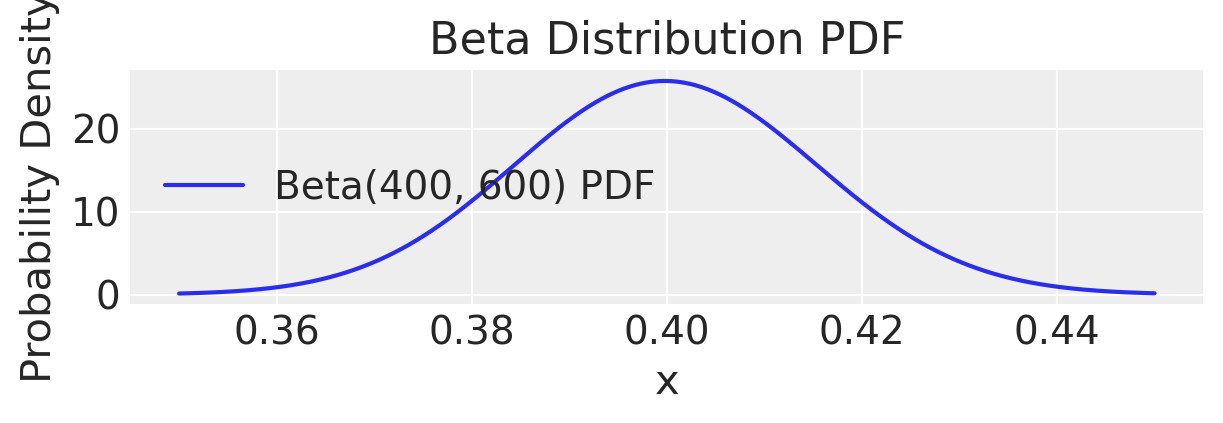

In [56]:
posterior_alpha = k + 1 - 1
posterior_beta = N - k + 1 - 1
x = np.linspace(0.35, .45, 1000)
pdf_values = sp.stats.beta.pdf(x, posterior_alpha, posterior_beta)

plt.figure(figsize=(6, 2)); plt.plot(x, pdf_values, label=f'Beta({posterior_alpha}, {posterior_beta}) PDF')
plt.title('Beta Distribution PDF'); plt.xlabel('x'); plt.ylabel('Probability Density'); plt.legend(); plt.show()

From here we can continue to a more complicated model. We generate data from a sine wave. In practice, this can be observed from temperature measurements over the course of 24 hours, or the positional observation of planets, which can also contain noise. However, the data used here is generated artificially.t

We make two Bayesian models: one using the original parametrisation, where we use a sine link-function, and in the other model we do not assume a parametric form and use B-splines to fit the curve.

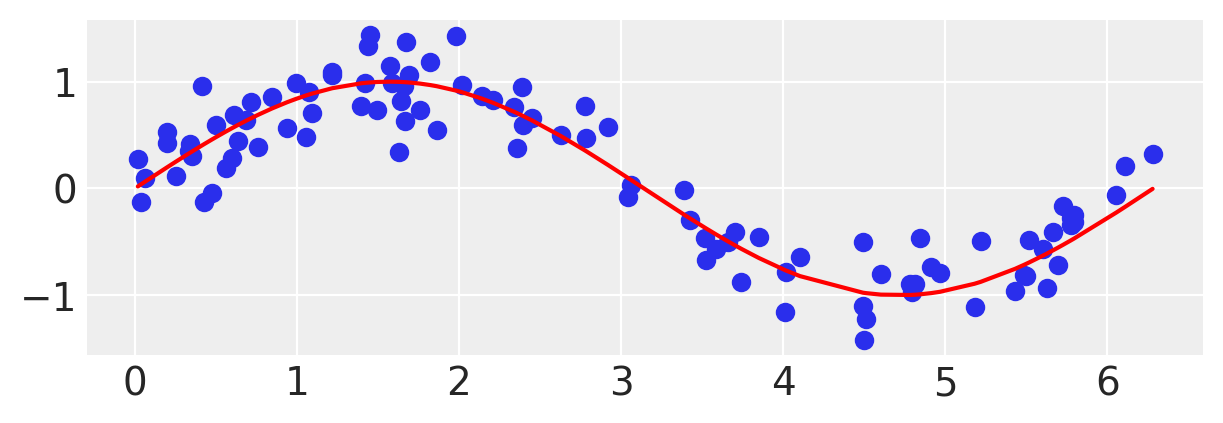

In [25]:
# Here we will generate some sinoid data. We will fit it two ways
# 1) Using a sine link function
# 2) Using a spline

N = 100
x = np.sort(np.random.uniform(0, 2*np.pi, N))
y = np.sin(x) + np.random.normal(0, 0.25, N)
plt.figure(figsize=(6,2)); plt.scatter(x, y)
plt.plot(x, np.sin(x), color="red")

df = pd.DataFrame({"x": x, "y": y})
df = df.sort_values("x")

Seeing the data, the amplitude lies somewhere between 0.5 and 1.5. This is information that can be put into a Bayesian model, something that is impossible in frequentist models. A period of the wave appears to be approximately 6.2, corresponding to a phi of 1. We apply a Normal prior that centers around 1. Other priors, such as Student-T or Cauchy have too much weight in the tails. In that case we do not make use of our knowledge of the context enough, therefore we do not use a Cauchy or Student-T prior. The deviation of the prior for the period is set to 0.2, such that 95% of the mass lies in the interval [0.8, 1.2]. We assume there is no shift in the phase.

Once there is more data, the power of the priors fade and the data speaks more. So any subjectivity that may be incorrect becomes less visible as the sample size increases. However, using properly used priors can be seen as a strength of Bayesian statistics because it is possible to impart knowledge into a model.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [amplitude, phi, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.


array([[<Axes: title={'center': 'amplitude'}>,
        <Axes: title={'center': 'amplitude'}>],
       [<Axes: title={'center': 'phi'}>, <Axes: title={'center': 'phi'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

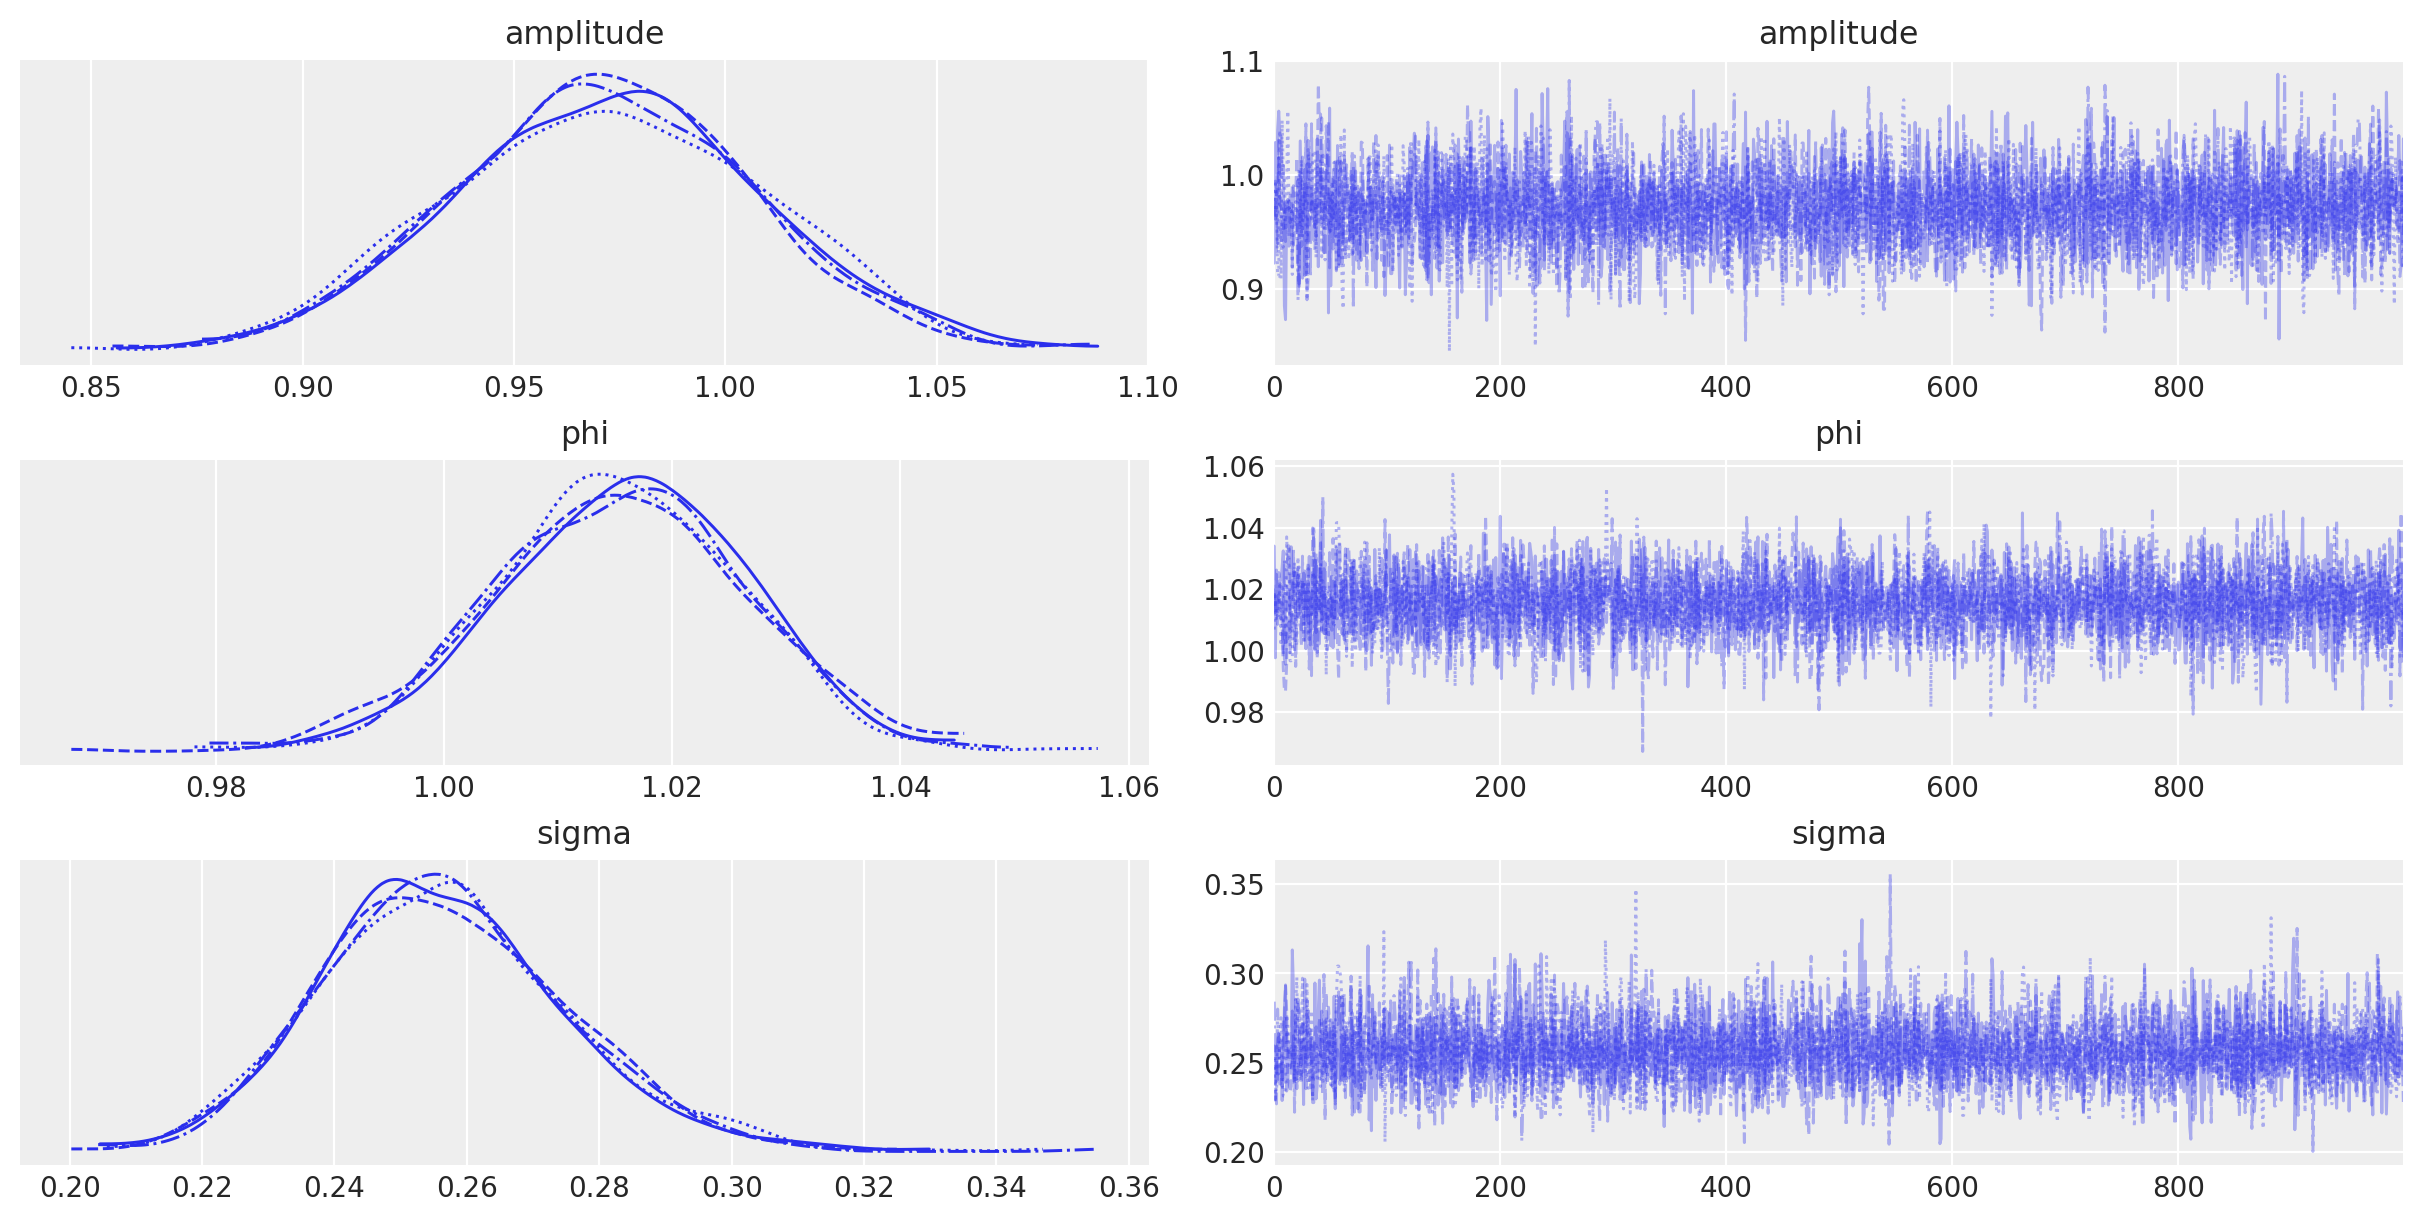

In [92]:
with pm.Model() as model_sine:
    
    # Priors for amplitude and standard error
    amplitude = pm.Uniform("amplitude", lower=0.5, upper=1.5)
    phi = pm.Normal("phi", mu=1, sigma=0.2)
    sigma = pm.HalfNormal("sigma", sigma=2)

    # Sine link-function
    mu = pm.Deterministic("mean", amplitude * pm.math.sin(phi * df["x"]))
    
    # Likelihood function and sampling
    likelihood = pm.Normal("likelihood", mu=mu, sigma=sigma, observed=df["y"])
    trace = pm.sample(1000)

az.plot_trace(trace, var_names=["amplitude", "phi", "sigma"])

Above the so-called trace plots are shown on the right. These are showing what happens in the sampling mathod under the hood. They should be very noisy, this shows that consequetive samples are (almost) not autocorrelated. This is a good thing as they should be independent. On the left, posterior distributions are shown for different parameters in the model. The values used for the data generation process are in the mode of each of the posterior distributions.

The posterior can be interpreted in many ways, depending on your philosophy of probability. A frequentist (standard statistics) would view this as the the uncertainty of parameter fits. They would conclude that the more narrow the posterior is, the narrower the 'confidence interval', the more precide their estimate is. A proponent of the Bayesian philosophy would disagree and claim that the posterior is the distribution of the parameter given the data $\theta|X$. There is much more to be said about this.

PyMC's model_to_graphviz function shows the hierarchical structure of a Bayesian model below.

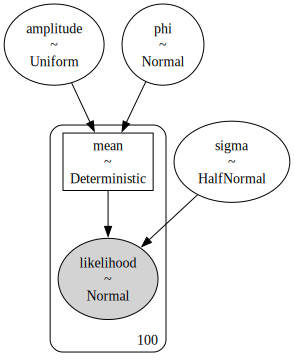

In [93]:
pm.model_to_graphviz(model_sine)

In [94]:
az.summary(trace, var_names=["amplitude", "sigma", "phi"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
amplitude  0.972  0.036   0.906    1.040        0.0      0.0    5484.0   
sigma      0.257  0.018   0.222    0.290        0.0      0.0    5383.0   
phi        1.015  0.011   0.996    1.035        0.0      0.0    5642.0   

           ess_tail  r_hat  
amplitude    3178.0    1.0  
sigma        3062.0    1.0  
phi          3303.0    1.0

Given the posterior samples seen above next to the trace plots, predictions can also be sampled, see below. Not only parameter 'uncertainty' is given, but also the predictive uncertainty of the response variable. Yellow is a 95% credibility interval where the data generating line lives. In red, lines are sampled from the posterior.

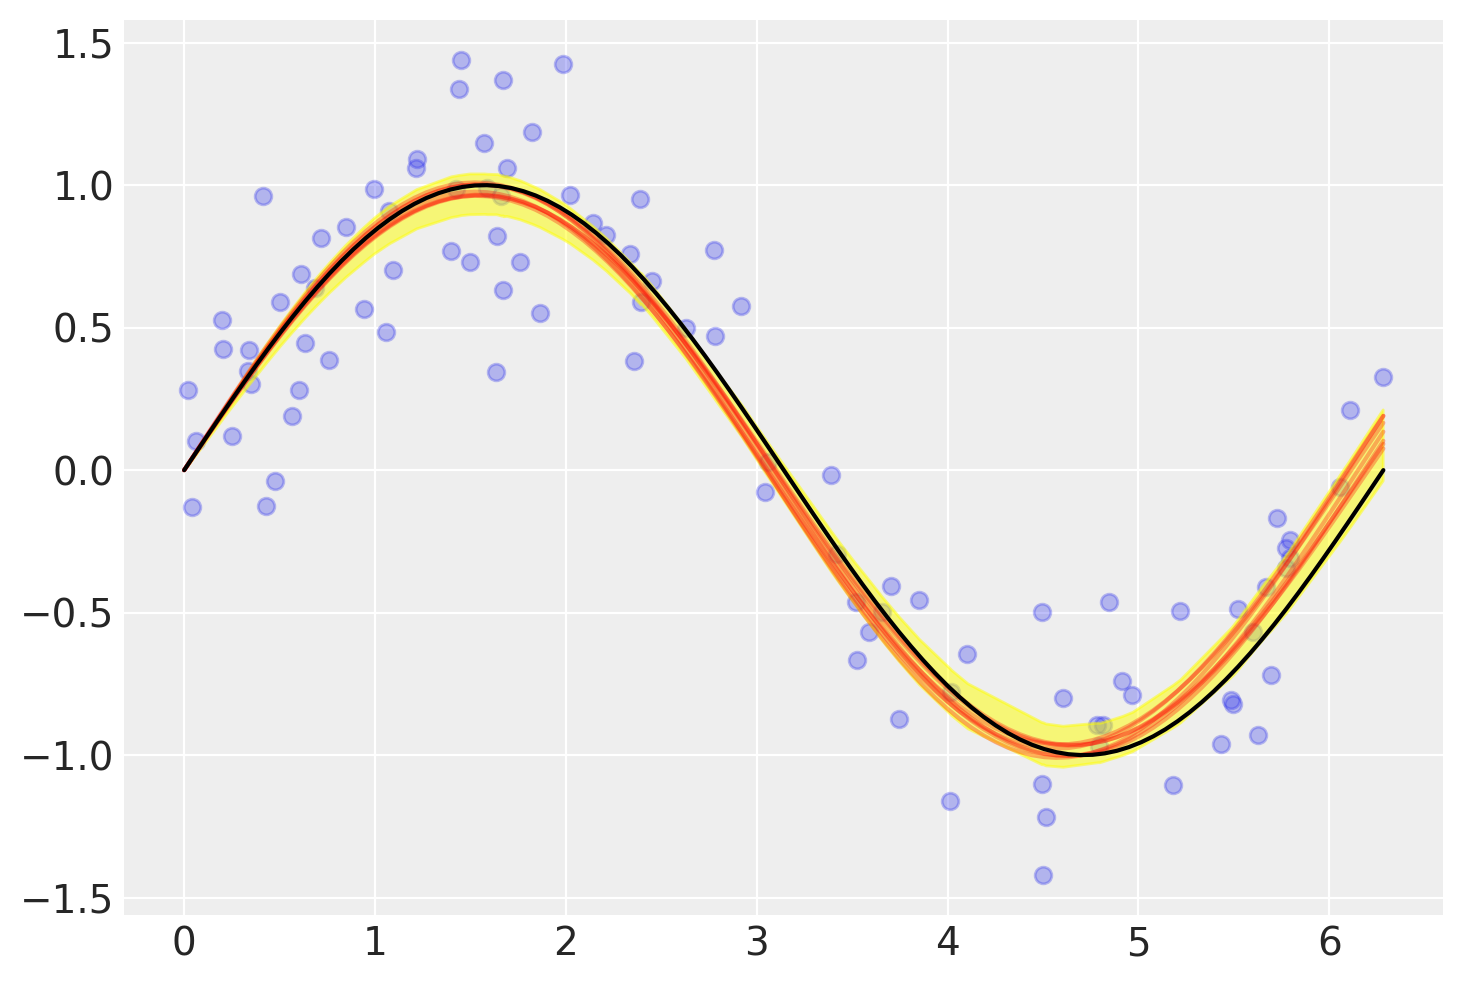

In [28]:
post_pred = az.summary(trace, var_names=["mean"]).reset_index(drop=True)

df_post = df.copy().reset_index(drop=True)
df_post["post_mean"] = post_pred["mean"]
df_post["post_lower"] = post_pred["hdi_3%"]
df_post["post_upper"] = post_pred["hdi_97%"]

# Plotting the credibility band of the regression curve
plt.scatter(x=df["x"], y=df["y"], alpha=.3)
plt.fill_between(df_post["x"], df_post["post_lower"], df_post["post_upper"], color="yellow", alpha=.5)

# Plotting samples of the posterior prediction
postsamp = az.extract(trace, num_samples=7)
x_plot = xr.DataArray(np.linspace(0, 2*np.pi, 100), dims="plot_id")

posterior_lines = postsamp["amplitude"] * np.sin(postsamp["phi"] * x_plot)
plt.plot(x_plot, posterior_lines.transpose(), alpha=0.3, color="red")
plt.plot(x_plot, np.sin(x_plot), color="black")
plt.show()

Without assuming a sinewave as underlying function, a more flexible approach can be applied. This is called a spline, which is more or less a weighted sum of a set of basis functions. The weights are the parameters that are to be fit/sampled. They are then multiplied with their basis functions and the weighted sum becomes the spline. here we will not go in depth on the number of knots and their locations.

In [38]:
knots = 4
knot_loc = np.quantile(df["x"], np. linspace(0, 1, knots))

B = dmatrix("bs(year, knots=knots, degree=3, include_intercept=True) - 1",
            {"year": df["x"], "knots": knot_loc[1:-1]})

array([[<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'intercept'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'w'}>, <Axes: title={'center': 'w'}>]],
      dtype=object)

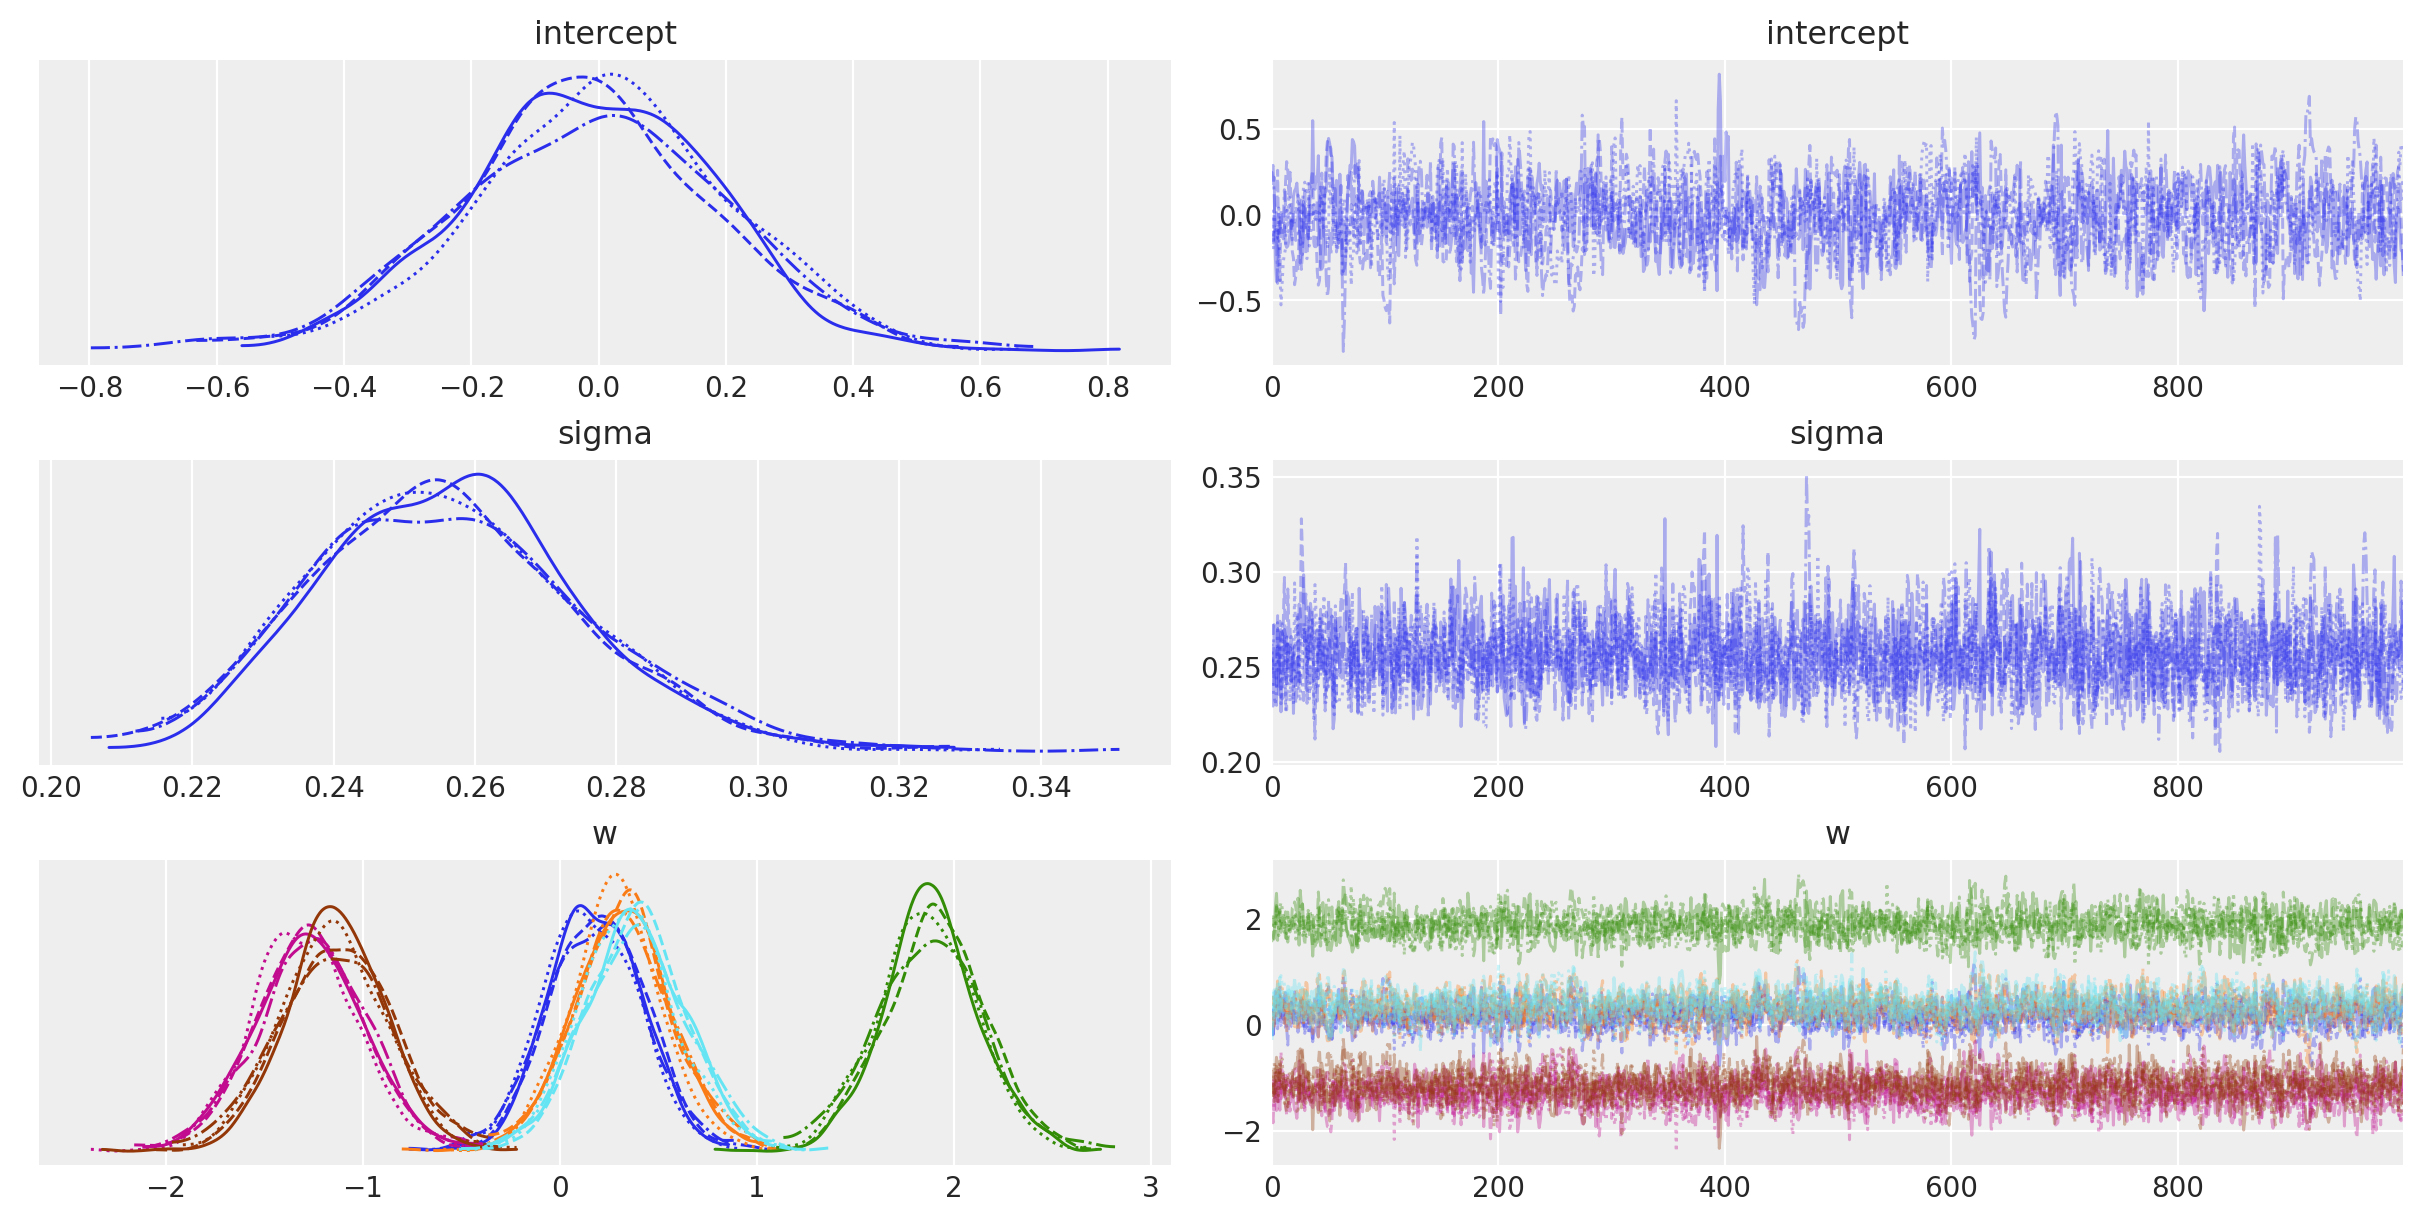

In [44]:
coords = {"splines": np.arange(B.shape[1])}

with pm.Model(coords=coords) as model_spline:
    # Prior for standard error and spline weights
    a = pm.Normal("intercept", 0, 0.2)
    sigma = pm.HalfNormal("sigma", sigma=1)
    w = pm.Normal("w", mu=0, sigma=10,size=B.shape[1], dims="splines")
    
    # Link-function
    mu = a + pm.Deterministic("mean", pm.math.dot(np.asarray(B, order="F"), w.transpose()))
    
    # Likelihood function and sampling
    likelihood = pm.Normal("likelihood", mu=mu, sigma=sigma, observed=df["y"])
    trace = pm.sample(1000)

az.plot_trace(trace, var_names=["intercept", "sigma", "w"])

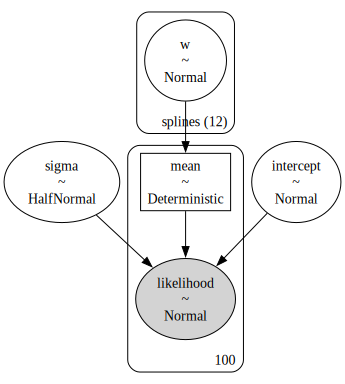

In [215]:
pm.model_to_graphviz(model_spline)

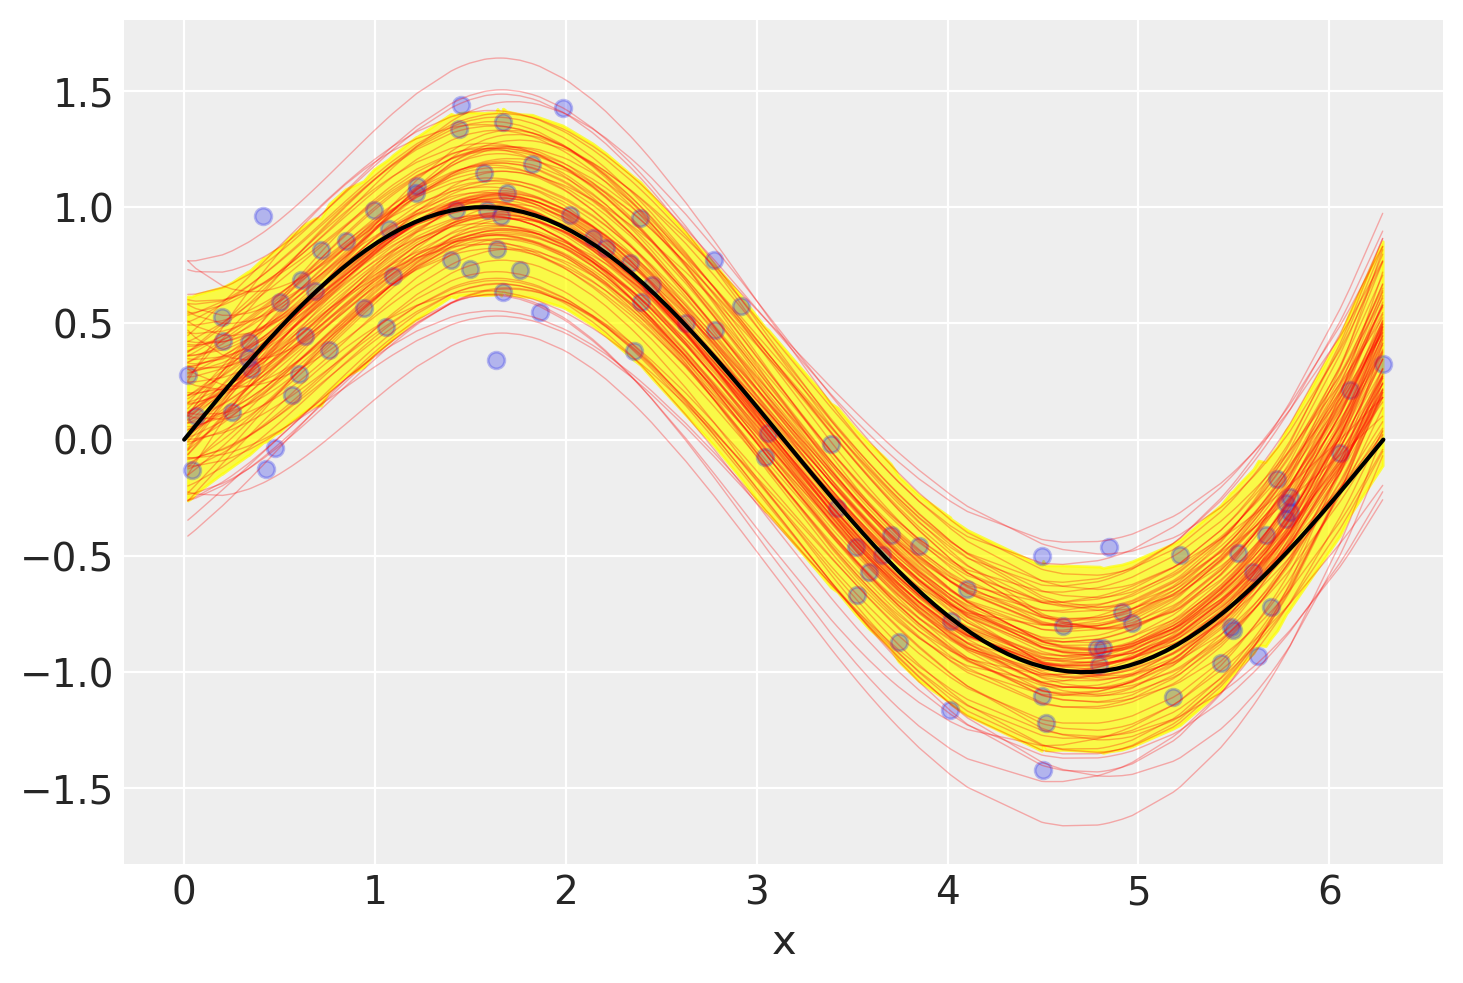

In [42]:
post_pred = az.summary(trace, var_names=["mean"]).reset_index(drop=True)

df_post = df.copy().reset_index(drop=True)
df_post["post_mean"] = post_pred["mean"]
df_post["post_lower"] = post_pred["hdi_3%"]
df_post["post_upper"] = post_pred["hdi_97%"]

# Plotting the credibility band of the regression curve
plt.fill_between(df_post["x"], df_post["post_lower"], df_post["post_upper"], color="yellow", alpha=.7)
plt.scatter(x=df["x"], y=df["y"], alpha=.3)

# Plotting samples of the posterior prediction
samples = 100
post_pred = az.extract(trace, num_samples=samples)
x_plot = xr.DataArray(np.linspace(0, 2*np.pi, 100), dims="plot_id")

for sample in range(samples):
    weights = post_pred["w"]
    post_line = (pd.DataFrame(np.dot(B, weights.T[sample]))
                 .assign(x=df["x"])
                 .melt("x", var_name="spline_i", value_name="value"))
    post_line.plot("x", "value", c="red", lw=0.5, alpha=.3, ax=plt.gca(),legend=False)
    
post_lines = np.dot(np.asarray(B, order="F"), post_pred["w"])
plt.plot(x_plot, np.sin(x_plot), color="black")
plt.show()

We can apply a horseshoe prior to prevent the weights becoming too big. For this, we use a relatively simple one taken from
http://proceedings.mlr.press/v5/carvalho09a/carvalho09a.pdf and can be added to the model easily by adding priors to the weights.

Normally, the Horseshoe prior consists of a global shrinkage parameter ($\tau$) and a local shrinkage parameter ($\lambda_i$). Due to a restricting prior on the local parameter, $\lambda_i$, it cannot obtain any value as large values may not be common in its prior distribution, therefore, it stays where the mass of the prior is. Given the local priors, the global shrinkage prior adds a further restriction to all local priors through multiplication, $\tau^2\lambda_i^2$. The latter will be the variance of the distribution where the weights are sampled from.

$w_i \sim N(0, \tau \lambda_i^2)$
$\lambda_i \sim Cauchy(0, 1)$
$\tau ~ HalfCauchy(1)$

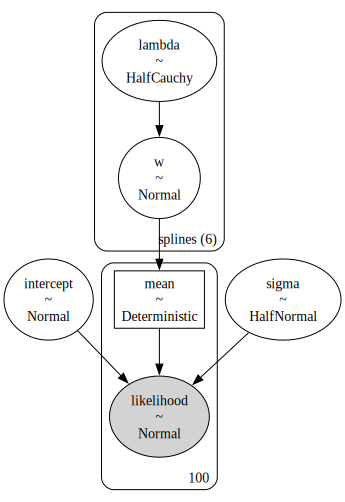

In [98]:
coords = {"splines": np.arange(B.shape[1])}

with pm.Model(coords=coords) as model_spline_reg:
    # Prior for standard error and spline weights
    a = pm.Normal("intercept", 0, 0.2)
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Applying regularising priors to spline weights
    #tau = pm.HalfCauchy("tau_horseshoe", 4)
    lam = pm.HalfCauchy("lambda", 2, dims="splines")
    #lam_sigma = tau*tau*lam*lam
    w = pm.Normal("w", mu=0, sigma=lam, size=B.shape[1], dims="splines")

    # Link-function
    mu = a + pm.Deterministic("mean", pm.math.dot(np.asarray(B, order="F"), w.transpose()))
    
    # Likelihood function and sampling
    likelihood = pm.Normal("likelihood", mu=mu, sigma=sigma, observed=df["y"])

pm.model_to_graphviz(model_spline_reg)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, sigma, tau_horseshoe, lambda, w]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 116 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 972 divergences after tuning. Increase `target_accept` or reparameterize.


array([[<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'intercept'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'w'}>, <Axes: title={'center': 'w'}>],
       [<Axes: title={'center': 'lambda'}>,
        <Axes: title={'center': 'lambda'}>]], dtype=object)

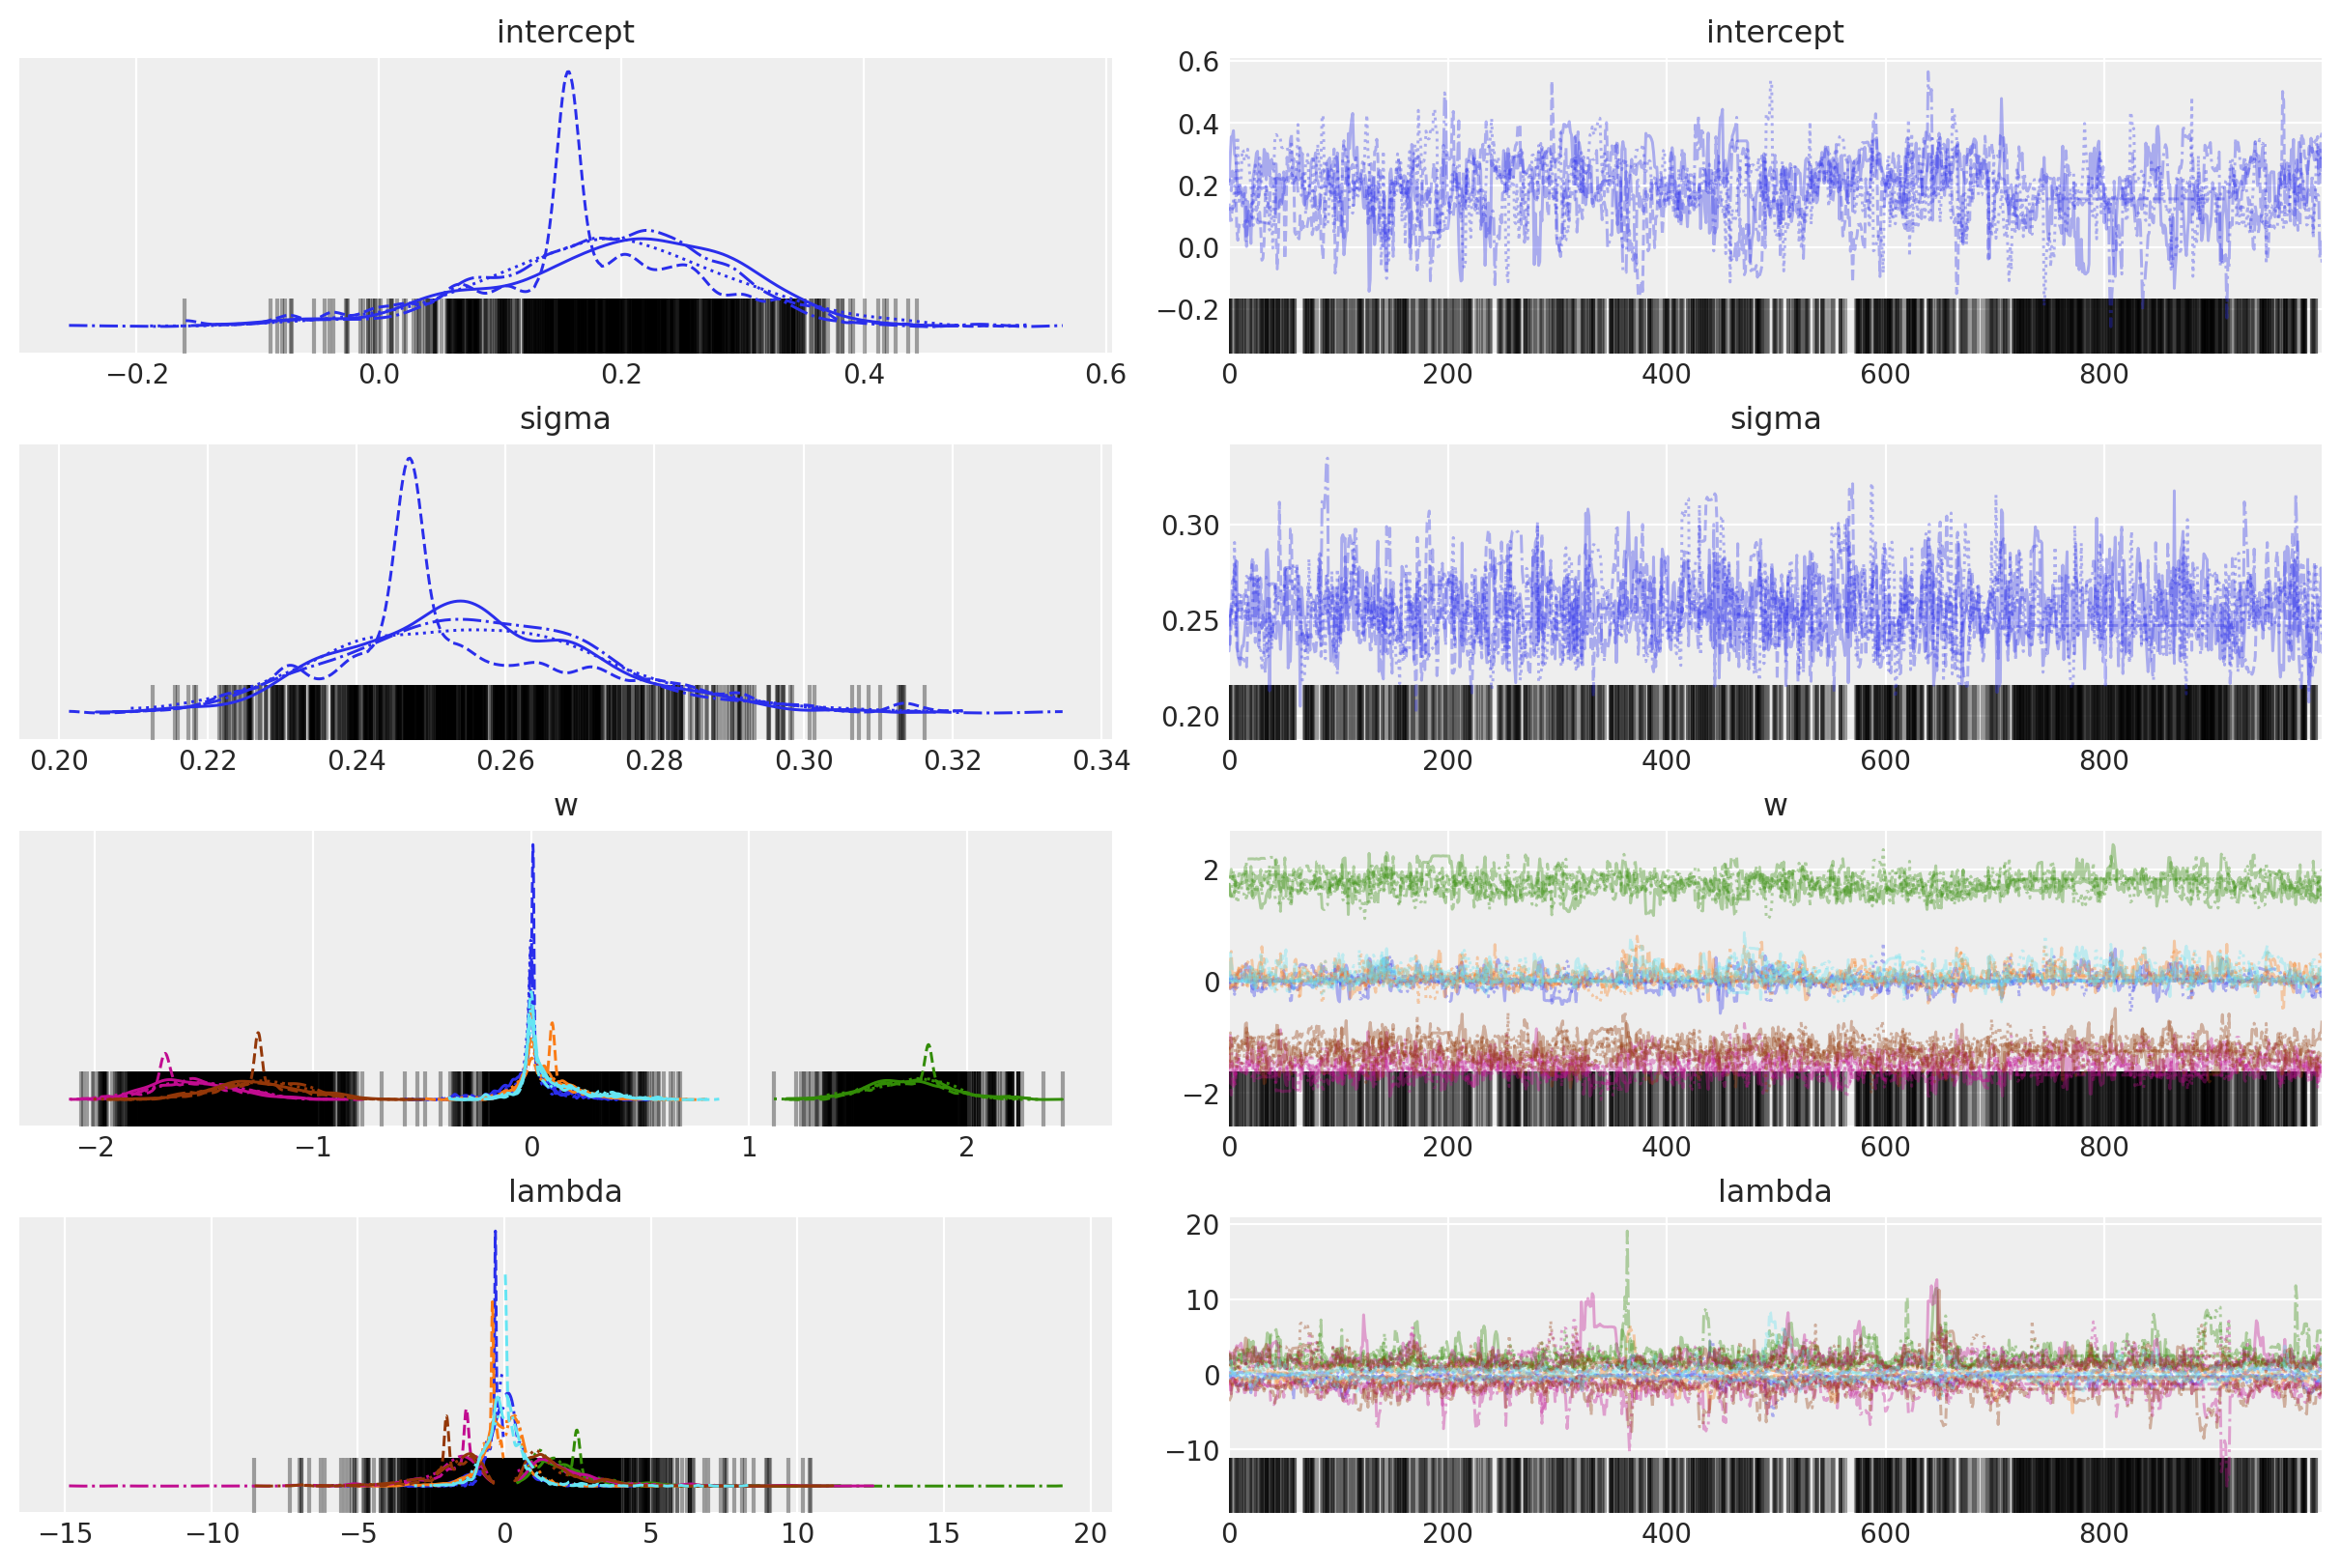

In [99]:
with model_spline:
    trace = pm.sample(1000)

az.plot_trace(trace, var_names=["intercept", "sigma", "w","lambda"])

Unfortunately, this leads to many divergences, meaning that the MCMC sampler was unstable, and sometimes yield samples that do not come from the actual posterior distribution. Often this implies a too restrictive or too diffuse model specification. The model needs to fix this.

Below, posterior predictions of the response variable are shown, the samples and credibility band appear to be biased, this is most likely due to the divergences.

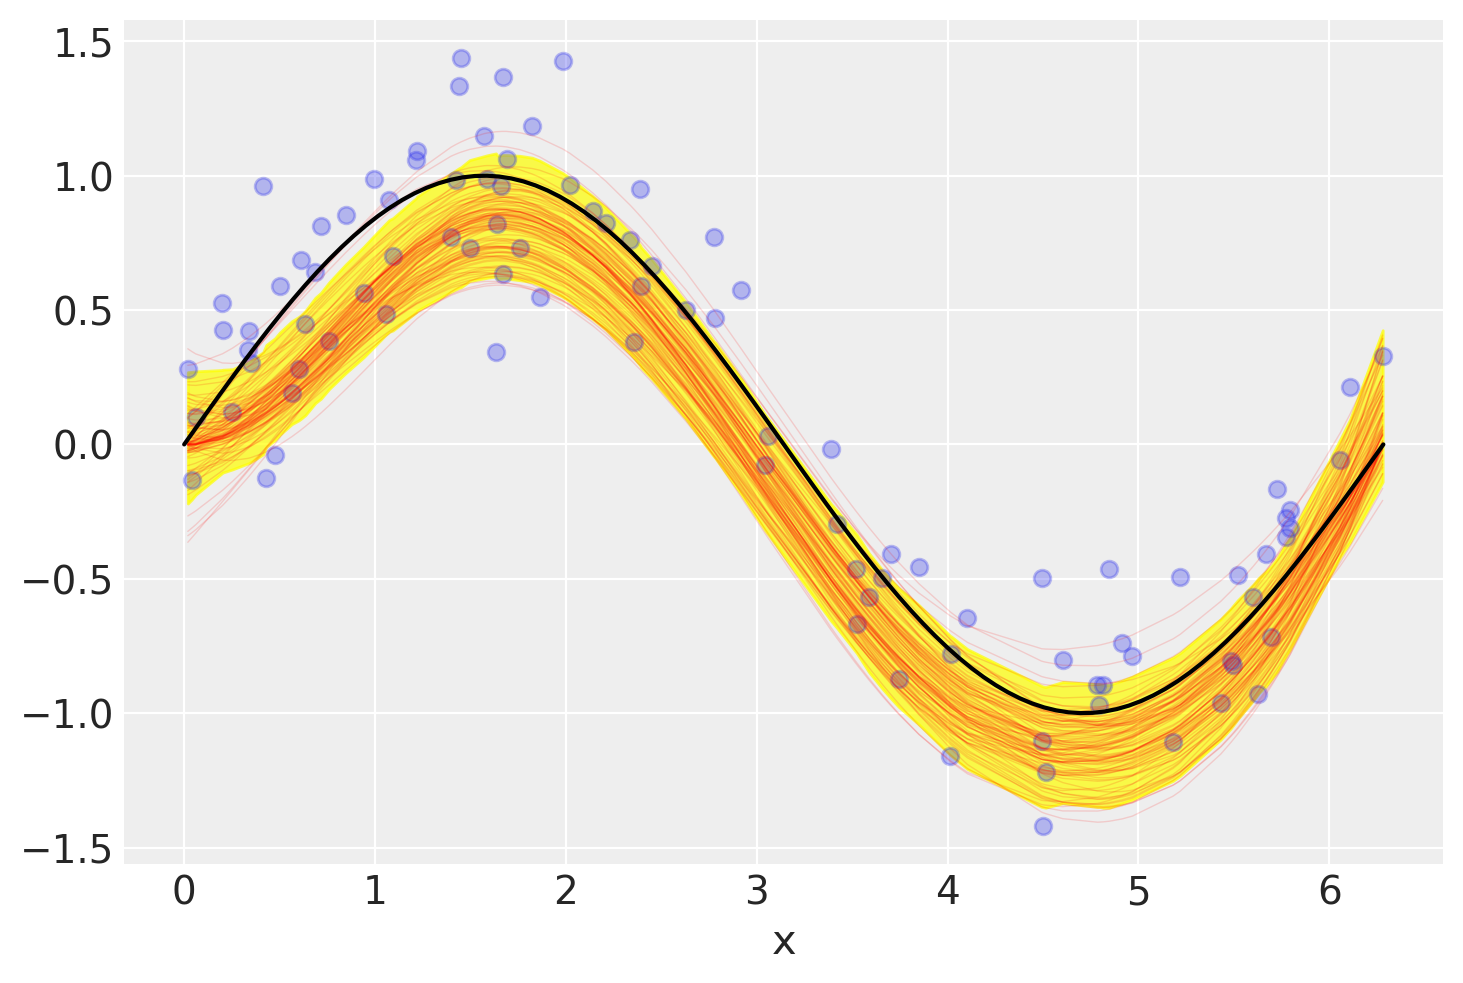

In [100]:
post_pred = az.summary(trace, var_names=["mean"]).reset_index(drop=True)

df_post = df.copy().reset_index(drop=True)
df_post["post_mean"] = post_pred["mean"]
df_post["post_lower"] = post_pred["hdi_3%"]
df_post["post_upper"] = post_pred["hdi_97%"]

# Plotting the credibility band of the regression curve
plt.fill_between(df_post["x"], df_post["post_lower"], df_post["post_upper"], color="yellow", alpha=.7)
plt.scatter(x=df["x"], y=df["y"], alpha=.3)

# Plotting samples of the posterior prediction
samples = 100
post_pred = az.extract(trace, num_samples=samples)
x_plot = xr.DataArray(np.linspace(0, 2*np.pi, 100), dims="plot_id")

for sample in range(samples):
    weights = post_pred["w"]
    post_line = (pd.DataFrame(np.dot(B, weights.T[sample]))
                 .assign(x=df["x"])
                 .melt("x", var_name="spline_i", value_name="value"))
    post_line.plot("x", "value", c="red", lw=0.5, alpha=.15, ax=plt.gca(),legend=False)
    
post_lines = np.dot(np.asarray(B, order="F"), post_pred["w"])
plt.plot(x_plot, np.sin(x_plot), color="black")
plt.show()